In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

In [2]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    max_pixel_value = 255.0
    return 20 * np.log10(max_pixel_value / np.sqrt(mse))

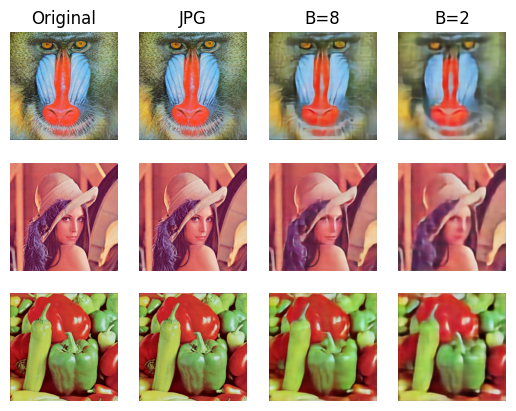

In [3]:
f, axarr = plt.subplots(3, 4)

psnr_jpg = []
psnr_soft = []
psnr_hard = []
bpp_original = []
bpp_jpg = []
bpp_soft = []
bpp_hard = []
IMAGE_SIZE = 512 * 512
for ax, col in zip(axarr[0], ['Original', "JPG", "B=8", "B=2"]):
    ax.set_title(col)

for i, name in enumerate(['baboon', 'lena', 'peppers']):
    original = Image.open(f'../assets/images/{name}.png')
    jpg_encoded = Image.open(f'../assets/jpegs/{name}.jpg')
    ae_soft_decoded = Image.open(f'../assets/decompressed/B=8/{name}.png')
    ae_hard_decoded = Image.open(f'../assets/decompressed/B=2/{name}.png')
    
    for ax in axarr[i]:
        ax.axis("off")
        

    axarr[i, 0].imshow(original)
    axarr[i, 1].imshow(jpg_encoded)
    axarr[i, 2].imshow(ae_soft_decoded)
    axarr[i, 3].imshow(ae_hard_decoded)

    psnr_jpg.append(psnr(np.asarray(original), np.asarray(jpg_encoded)))
    psnr_soft.append(psnr(np.asarray(original), np.asarray(ae_soft_decoded)))
    psnr_hard.append(psnr(np.asarray(original), np.asarray(ae_hard_decoded)))

    bpp_original.append((os.path.getsize(f'../assets/images/{name}.png') * 8) / IMAGE_SIZE)
    bpp_jpg.append((os.path.getsize(f'../assets/jpegs/{name}.jpg') * 8) / IMAGE_SIZE)
    bpp_soft.append((os.path.getsize(f'../assets/compressed/B=8/{name}.bin') * 8) / IMAGE_SIZE)
    bpp_hard.append((os.path.getsize(f'../assets/compressed/B=2/{name}.bin') * 8) / IMAGE_SIZE)
    
plt.savefig("../assets/graphs/quality-comparison.png")

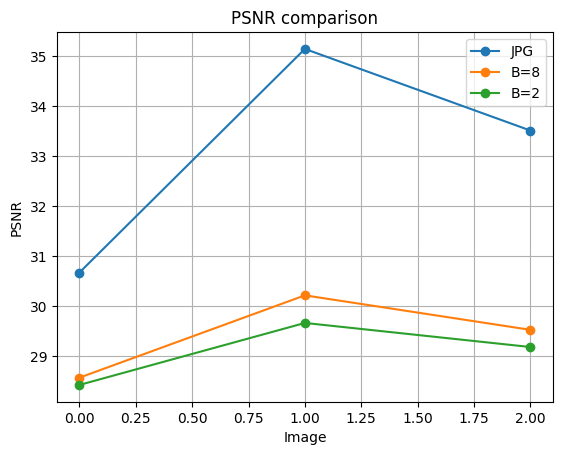

In [4]:
plt.plot(psnr_jpg, '-o', label='JPG')
plt.plot(psnr_soft, '-o', label='B=8')
plt.plot(psnr_hard, '-o', label='B=2')
plt.grid()
plt.xlabel('Image')
plt.ylabel('PSNR')
plt.title('PSNR comparison')
plt.legend()
plt.savefig("../assets/graphs/psnr.png")

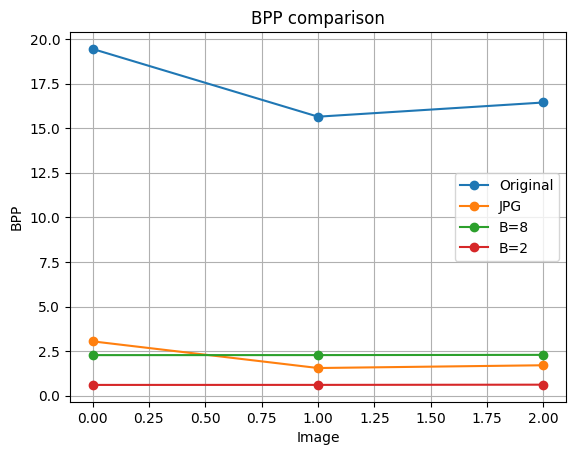

In [5]:
plt.grid()
plt.plot(bpp_original, '-o', label='Original')
plt.plot(bpp_jpg, '-o', label='JPG')
plt.plot(bpp_soft, '-o', label='B=8')
plt.plot(bpp_hard, '-o', label='B=2')
plt.xlabel('Image')
plt.ylabel('BPP')
plt.title('BPP comparison')
plt.legend()
plt.savefig("../assets/graphs/bpp.png")